In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats

In [2]:
figure_path = './figures'
os.makedirs(figure_path, exist_ok=True)

In [3]:
parameters = {
    'A': {
        'incidence': 0.2,
        'beta_counts': 10,
        'color': 'b'
    },
    'B': {
        'incidence': 0.10,
        'beta_counts': 25,
        'color': 'g'
    }
}

In [4]:
# Compute beta parameters
for key, value in parameters.items():
    parameters[key]['alpha'] = value['incidence'] * value['beta_counts']
    parameters[key]['beta'] = (1-value['incidence']) * value['beta_counts']
    
    # Compute the unconditional distribution
    parameters[key]['x'] = np.linspace(
        scipy.stats.beta.ppf(0.00, parameters[key]['alpha'], parameters[key]['beta']),
        scipy.stats.beta.ppf(0.999, parameters[key]['alpha'], parameters[key]['beta']), 
        100
    )
    parameters[key]['x'] = np.linspace(
        0.0001,
        0.9999,
        10000
    )
    parameters[key]['pdf'] = scipy.stats.beta.pdf(parameters[key]['x'], parameters[key]['alpha'], parameters[key]['beta'])
    
    # Compute the conditional distributions
    parameters[key]['pdf_1'] = parameters[key]['x']*parameters[key]['pdf'] / parameters[key]['incidence']
    parameters[key]['pdf_0'] = (1-parameters[key]['x'])*parameters[key]['pdf'] / (1-parameters[key]['incidence'])
    parameters[key]['calibration_curve'] = (parameters[key]['pdf_1']*parameters[key]['incidence']) / parameters[key]['pdf']
    
    parameters[key]['calibration_curve_map'] = {key: value for key, value in zip(parameters[key]['x'], parameters[key]['calibration_curve'])}
    

In [5]:
# New group A-new, as a transformation of A to the conditional distributions of B
key = 'A-new'
source_group = 'A'
target_group = 'B'

parameters[key] = {'incidence': parameters[source_group]['incidence'], 'color': 'b'}

parameters[key]['x'] = np.linspace(
    0.0001,
    0.9999,
    10000
)

# Compute the conditional distributions
parameters[key]['pdf_1'] = parameters[target_group]['pdf_1']
parameters[key]['pdf_0'] = parameters[target_group]['pdf_0']
parameters[key]['pdf'] = (parameters[key]['pdf_1']*parameters[key]['incidence']) + (parameters[key]['pdf_0']*(1-parameters[key]['incidence']))
parameters[key]['calibration_curve'] = (parameters[key]['pdf_1']*parameters[key]['incidence']) / parameters[key]['pdf']


In [6]:
def plot_distributions(
    parameters,
    plot_x='x', 
    plot_y='pdf', 
    ax=plt.gca(), 
    groups = None, 
    title='', 
    legend=False, 
    apply_fill=True,
    fill_min=None, 
    fill_max=None,
    threshold = None,
    calibration_curve=False
):
    
    if groups is None:
        groups = parameters.keys()
        
    for key in groups:
        
        ax.plot(parameters[key][plot_x], parameters[key][plot_y], color=parameters[key]['color'])
        
        if apply_fill:
            if fill_min is None:
                fill_min = parameters[key][plot_x].min()
            if fill_max is None:
                fill_max = parameters[key][plot_x].max()

            fill_mask = (parameters[key][plot_x] >= fill_min) & (parameters[key][plot_x] <= fill_max)
            ax.fill_between(
                parameters[key][plot_x][fill_mask], 0, parameters[key][plot_y][fill_mask], color=parameters[key]['color'], alpha=0.5, label=f'Group {key}'
            )
        if threshold is not None:
            ax.axvline(threshold, color='k', linestyle='--')
            
        if calibration_curve:
            # Plot a dashed x=y for comparison with perfect calibration
            ax.plot(parameters[key][plot_x], parameters[key][plot_x], linestyle='--', color='gray')

    ax.set_xlim([0, 1])
    ax.set_title(title, fontsize=16)

In [7]:
def get_performance_metrics(parameters, threshold):
    result = {key: {} for key in parameters.keys()}
    for key, value in parameters.items():
        the_x = parameters['A']['x']
        threshold_mask = the_x >= threshold
        threshold_neg_mask = the_x < threshold
        
        result[key]['TPR'] = scipy.integrate.cumulative_trapezoid(
            y=value['pdf_1'][threshold_mask], 
            x=the_x[threshold_mask]
        )[-1]

        result[key]['FNR'] = scipy.integrate.cumulative_trapezoid(
            y=value['pdf_1'][threshold_neg_mask], 
            x=the_x[threshold_neg_mask]
        )[-1]
            
        result[key]['FPR'] = scipy.integrate.cumulative_trapezoid(
            y=value['pdf_0'][threshold_mask], 
            x=the_x[threshold_mask]
        )[-1]
        
        result[key]['TNR'] = scipy.integrate.cumulative_trapezoid(
            y=value['pdf_0'][threshold_neg_mask], 
            x=the_x[threshold_neg_mask]
        )[-1]
        
        if 'alpha' in value.keys():
            result[key]['PPV'] = scipy.stats.beta.expect(
                scipy.interpolate.interp1d(value['x'], value['calibration_curve']),
                args=(value['alpha'], value['beta']), 
                lb=threshold, 
                conditional=True
            )
        
    return result
    
threshold=0.25
performance_metrics = get_performance_metrics(parameters, threshold)
pd.DataFrame(performance_metrics)

,A,B,A-new
TPR,0.525368,0.057947,0.057947
FNR,0.474332,0.941927,0.941927
FPR,0.243856,0.015983,0.015983
TNR,0.755918,0.983975,0.983975
PPV,0.350000,0.287092,NaN


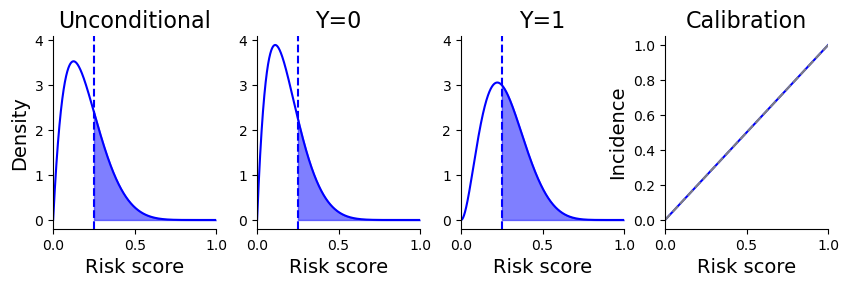

In [8]:
# Plot for group A

plt.close()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,2.5), sharey=False, sharex=True)
axes = [ax1, ax2, ax3, ax4]

threshold = 0.25
    
plot_distributions(parameters, plot_y='pdf', ax=ax1, title='Unconditional', groups='A', fill_min=threshold, threshold=threshold)
plot_distributions(parameters, plot_y='pdf_0', ax=ax2, title='Y=0', groups='A', fill_min=threshold, threshold=threshold)
plot_distributions(parameters, plot_y='pdf_1', ax=ax3, title='Y=1', groups='A', fill_min=threshold, threshold=threshold)

plot_distributions(parameters, 
    plot_y='calibration_curve', 
    ax=ax4, 
    title='Calibration', 
    groups='A', 
    apply_fill=False, 
    calibration_curve=True
)

fig.subplots_adjust(wspace=0.25)
ax1.set_ylabel('Density', fontsize=14)

ax4.set_ylabel('Incidence', fontsize=14)
for ax in axes:
    ax.set_xlabel('Risk score', fontsize=14)

ax1.sharey(ax2)
ax3.sharey(ax2)

sns.despine()
plt.show()
fig.savefig(os.path.join(figure_path, 'one_group_distributions.png'), dpi=300, bbox_inches="tight")

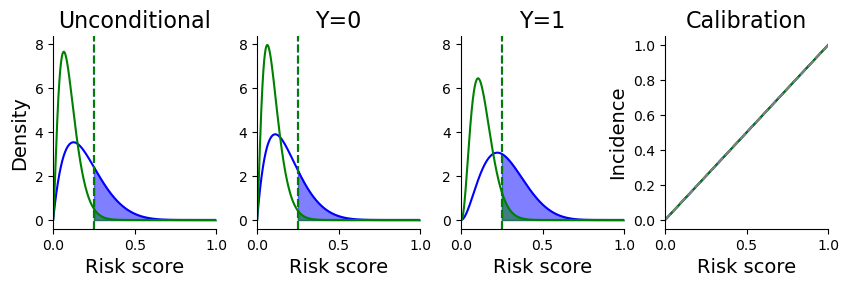

In [9]:
# Plot A and B

plt.close()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,2.5), sharey=False, sharex=True)
axes = [ax1, ax2, ax3, ax4]

threshold = 0.25
    
plot_distributions(parameters, plot_y='pdf', ax=ax1, groups = ['A', 'B'], title='Unconditional', fill_min=threshold, threshold=threshold)
plot_distributions(parameters, plot_y='pdf_0', ax=ax2, groups = ['A', 'B'], title='Y=0', fill_min=threshold, threshold=threshold)
plot_distributions(parameters, plot_y='pdf_1', ax=ax3, groups = ['A', 'B'], title='Y=1', fill_min=threshold, threshold=threshold)

plot_distributions(parameters, plot_y='calibration_curve', ax=ax4, title='Calibration', apply_fill=False, 
                   groups=['A', 'B'],
                   calibration_curve=True)

fig.subplots_adjust(wspace=0.25)
ax1.set_ylabel('Density', fontsize=14)

ax4.set_ylabel('Incidence', fontsize=14)
for ax in axes:
    ax.set_xlabel('Risk score', fontsize=14)

ax1.sharey(ax2)
ax3.sharey(ax2)

sns.despine()
plt.show()
fig.savefig(os.path.join(figure_path, 'two_group_distributions.png'), dpi=300, bbox_inches="tight")

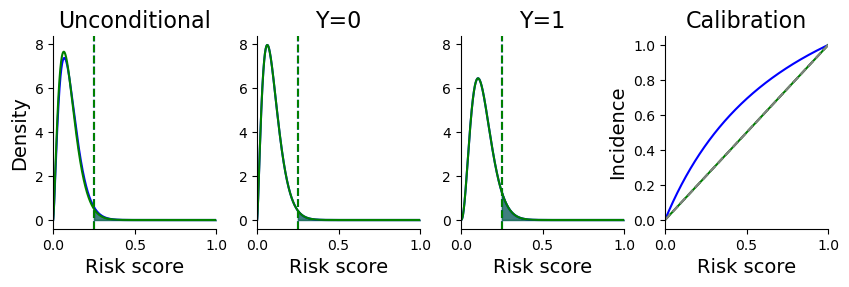

In [10]:
# Plot A-new and B

plt.close()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,2.5), sharey=False, sharex=True)
axes = [ax1, ax2, ax3, ax4]

threshold = 0.25
    
plot_distributions(parameters, plot_y='pdf', ax=ax1, groups = ['A-new', 'B'], title='Unconditional', fill_min=threshold, threshold=threshold)
plot_distributions(parameters, plot_y='pdf_0', ax=ax2, groups = ['A-new', 'B'], title='Y=0', fill_min=threshold, threshold=threshold)
plot_distributions(parameters, plot_y='pdf_1', ax=ax3, groups = ['A-new', 'B'], title='Y=1', fill_min=threshold, threshold=threshold)

plot_distributions(parameters, plot_y='calibration_curve', ax=ax4, title='Calibration', apply_fill=False, 
                   groups=['A-new', 'B'],
                   calibration_curve=True)

fig.subplots_adjust(wspace=0.25)
ax1.set_ylabel('Density', fontsize=14)

ax4.set_ylabel('Incidence', fontsize=14)
for ax in axes:
    ax.set_xlabel('Risk score', fontsize=14)

ax1.sharey(ax2)
ax3.sharey(ax2)

sns.despine()
plt.show()
fig.savefig(os.path.join(figure_path, 'two_group_distributions_miscalibrated.png'), dpi=300, bbox_inches="tight")